In [1]:
"""
Created on Tue Nov 28 20:28:42 2020

@author: Armando Alvarez Rolins

Title: Housing Prices Predictive Analysis

Description: Predict sales price for housing based on market data
"""
# Linear Algebra and Data Processing
import numpy as np
import pandas as pd
import requests
import os
import datetime
import sklearn as sk
# Modeling
from sklearn.model_selection import (GridSearchCV)
# Random
import random
# Plotting
import matplotlib.pyplot as plt

# Data Extraction

In [2]:
# Data Extraction
df_house_test = pd.read_csv("./test.csv")
df_house_train = pd.read_csv("./train.csv")

print(df_house_test.info())
print("\n")
print(df_house_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

A brief look at the test and train data confirms they have the same number of features with the additional "SalePrice" which is the dependent variable we are going to predict on the test data set

In [3]:
# Defining features
features = pd.concat([df_house_train.drop(['Id', 'SalePrice'], axis=1), df_house_test.drop(['Id'], axis=1)])

# Transform MSSubClass into string because numbers correspond to code, not a continuous scale
features['MSSubClass'] = features['MSSubClass'].apply(str)

# Separating feature types
time_features = [feature for feature in features.columns if 'Yr' in feature or 'Year' in feature \
                 or 'Mo' in feature or 'Month' in feature or 'Dy' in feature or 'Day' in feature]
cat_features = features.select_dtypes(include=['object']).columns.tolist()
num_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(time_features,'\n')
print(cat_features,'\n')
print(num_features,'\n')

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'] 

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrB

## Analyzing Data Sparsity

Text(0.5, 1.0, 'Percentage of Empty Values per Feature')

<Figure size 432x288 with 0 Axes>

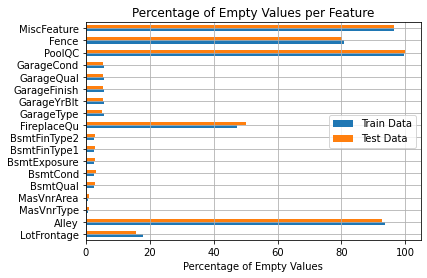

In [4]:
# Check number of Na in the dataframe
empty_values = df_house_train.isna().sum().apply(lambda x: x*100/len(df_house_train.index))
empty_values = pd.concat([empty_values, df_house_test.isna().sum().apply(lambda x: x*100/len(df_house_test.index))], \
                         axis=1)
empty_values.columns=['Train Data', 'Test Data']
empty_values = empty_values.loc[(empty_values!=0).all(axis=1)]

# Plot Figure
plt.figure()
empty_values.plot.barh(grid=1) #figsize=(10,20)
plt.xlabel('Percentage of Empty Values')
plt.title('Percentage of Empty Values per Feature')

Not all of this data is useless though, here we analyze each feature and the relevance of their null values.
* **MiscFeature:**
    Null Value means no miscellaneous feature
* **Fence:**
    Null Value means no fence.
* **PoolQC:**
    Null Value means no pool.
* **GarageCond, GarageQual, GarageFinish, GarageType:**
    Null Value means no garage
* **FireplaceQu**:
    Null Value means no fireplace
* **BsmtFinType2, BsmtFinType1, BsmtExposure, BsmtCond, BsmtQua:**
    Null Value means no basement
* **MasVnrArea, MasVnrType:**
    Null Value not described
* **Alley:**
    Null Value means no Alley
* **Lot Frontage:**
    Null Value not described
    
So it is clear that in most of these cases the null value do not mean missing data, it is contemplated in the data description and just means the absence of such a feature. This data is still usable.

For the case of Masonry Veneer, because the amount of null values is less than 20%, it is safe to assume that null values correspond to the None category (and 0 area), that is: the house in question does not have masonry veneer.

For the case of Lot Frontage, it is obvious that a house cannot have 0 lot frontage. Because the percentage of null values in this feature is also less than 20%, I shall imput the missing values with an average value, expecting to introduce only an acceptably small amount of bias.

# Feature Engineering

## Handling Empty Values / Imputing

In [8]:
# Transforming Masonry Veneer null values into 'None'
df_house_train['MasVnrArea'].fillna(0, inplace=True)
df_house_train['MasVnrType'].fillna('None', inplace=True)
df_house_test['MasVnrArea'].fillna(0, inplace=True)
df_house_test['MasVnrType'].fillna('None', inplace=True)

# Imputing LotFrontage null values
df_house_train['LotFrontage'].fillna(df_house_train['LotFrontage'].mean(), inplace=True)
df_house_test['LotFrontage'].fillna(df_house_test['LotFrontage'].mean(), inplace=True)

# Possible conversion of remainin null values to string?

LotFrontage    0
LotFrontage    1
dtype: int64
LotFrontage    0
LotFrontage    1
dtype: int64
0
